### Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('SeoulBikeData.csv',encoding='cp949')
df.head(5)

,Date,Rented Bike Count,Hour,Temperature(캜),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(캜),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
df.isnull().sum() #check no missing data

Date                        0
Rented Bike Count           0
Hour                        0
Temperature(캜)              0
Humidity(%)                 0
Wind speed (m/s)            0
Visibility (10m)            0
Dew point temperature(캜)    0
Solar Radiation (MJ/m2)     0
Rainfall(mm)                0
Snowfall (cm)               0
Seasons                     0
Holiday                     0
Functioning Day             0
dtype: int64

In [4]:
df.rename(columns={'Temperature(°C)': 'Temperature',
                   'Humidity(%)': 'Humidity',
                   'Wind speed (m/s)': 'Wind Speed',
                   'Visibility (10m)': 'Visibility',
                   'Dew point temperature(°C)': 'Dew Point',
                   'Solar Radiation (MJ/m2)': 'Solar Radiation',
                   'Rainfall(mm)': 'Rainfall',
                   'Snowfall (cm)': 'Snowfall'},
          inplace=True)

In [5]:
df[(df['Functioning Day'] == 'No') & (df['Rented Bike Count'] != 0)] #check no bikes rented on no-functioning days

,Date,Rented Bike Count,Hour,Temperature(캜),Humidity,Wind Speed,Visibility,Dew point temperature(캜),Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day


In [6]:
df = df[df['Functioning Day'] == 'Yes']  
print(f"data_shape: {df.shape}")

data_shape: (8465, 14)


In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')  # uniform date format
df['Month'] = df['Date'].dt.month  # extract months for seasonal analysis
df['Day'] = df['Date'].dt.strftime('%a')  # the abbreviation of the day of the week, used for pattern analysis
df['Weekend'] = (df['Day'] == 'Sat') | (df['Day'] == 'Sun')  # weekend
df['Work Day'] = (df['Weekend'] == False) & (df['Holiday'] == "No Holiday")  # work_day

The time feature creation has been completed

In [8]:
original_target = df['Rented Bike Count']
print("original_target.description:")
print(original_target.describe())

original_target.description:
count    8465.000000
mean      729.156999
std       642.351166
min         2.000000
25%       214.000000
50%       542.000000
75%      1084.000000
max      3556.000000
Name: Rented Bike Count, dtype: float64


In [9]:
cutoff = original_target.median()
mean_value = original_target.mean()
print(f"\n dividing point:")
print(f"median: {cutoff:.2f} ")
print(f"mean_value: {mean_value:.2f}")


 dividing point:
median: 542.00 
mean_value: 729.16


In [10]:
y_binary = (original_target > cutoff).astype(int)

In [11]:
class_distribution = pd.Series(y_binary).value_counts().sort_index()
class_proportions = pd.Series(y_binary).value_counts(normalize=True).sort_index()

In [12]:
print(f"\nclass_distribution:")
print(f"0 (low_demand): {class_distribution[0]} sample ({class_proportions[0]*100:.2f}%)")
print(f"1 (high_demand): {class_distribution[1]} sample ({class_proportions[1]*100:.2f}%)")


class_distribution:
0 (low_demand): 4234 sample (50.02%)
1 (high_demand): 4231 sample (49.98%)


In [13]:
imbalance_ratio = max(class_proportions) / min(class_proportions)
print(f"class_unbalance_proportion: {imbalance_ratio:.2f}")

if imbalance_ratio > 2:
    print("warning: There is an obvious category imbalance")
else:
    print("The category distribution is relatively balanced")

class_unbalance_proportion: 1.00
The category distribution is relatively balanced


In [14]:
feature_columns = ['Hour', 'Temperature(캜)', 'Humidity', 'Wind Speed', 'Visibility',
                   'Dew point temperature(캜)', 'Solar Radiation', 'Rainfall', 'Snowfall',
                   'Seasons', 'Work Day']
X = df[feature_columns]
categorical_col = X.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()
numerical_col = [col for col in X.columns if col not in categorical_col]

In [15]:
print(f"shape_of_feature_columns: {X.shape}")

shape_of_feature_columns: (8465, 11)


In [16]:
categorical_col = X.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()
numerical_col = [col for col in X.columns if col not in categorical_col]

In [17]:
print(f"classification_feature: {categorical_col}")
print(f"numerical_feature: {numerical_col}")

classification_feature: ['Seasons', 'Work Day']
numerical_feature: ['Hour', 'Temperature(캜)', 'Humidity', 'Wind Speed', 'Visibility', 'Dew point temperature(캜)', 'Solar Radiation', 'Rainfall', 'Snowfall']


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [19]:
encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_col)
    ],
    remainder='passthrough'  # keep numerical features unchanged
)

In [20]:
X_enc = encoder.fit_transform(X)

In [21]:
categorical_enc = encoder.named_transformers_['cat'].get_feature_names_out(categorical_col)
all_col_enc = list(categorical_enc) + numerical_col
X_enc_df = pd.DataFrame(X_enc, columns=all_col_enc)

print(f"shape_of_after_coding_feature: {X_enc_df.shape}")
print(f"name_of_after_coding_column: {all_col_enc[:8]}...") 

shape_of_after_coding_feature: (8465, 15)
name_of_after_coding_column: ['Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter', 'Work Day_False', 'Work Day_True', 'Hour', 'Temperature(캜)']...


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_enc_df, 
    y_binary, 
    test_size=0.25, 
    random_state=123,  
    stratify=y_binary 
)

print(f"shape_of_training_set: {X_train.shape}")
print(f"shape_of_test_set: {X_test.shape}")
print(f"category_distribution_training: {pd.Series(y_train).value_counts().tolist()}")
print(f"category_distribution_test: {pd.Series(y_test).value_counts().tolist()}")

shape_of_training_set: (6348, 15)
shape_of_test_set: (2117, 15)
category_distribution_training: [3175, 3173]
category_distribution_test: [1059, 1058]


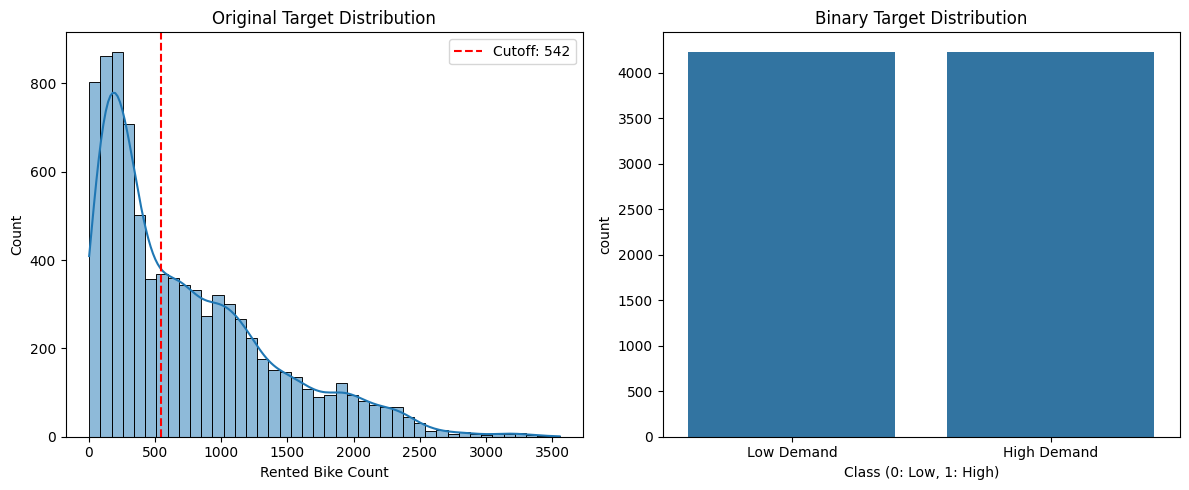

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(original_target, kde=True)
plt.axvline(cutoff, color='red', linestyle='--', label=f'Cutoff: {cutoff:.0f}')
plt.title('Original Target Distribution')
plt.xlabel('Rented Bike Count')
plt.legend()

plt.subplot(1, 2, 2)
sns.countplot(x=y_binary)
plt.title('Binary Target Distribution')
plt.xlabel('Class (0: Low, 1: High)')
plt.xticks([0, 1], ['Low Demand', 'High Demand'])

plt.tight_layout()
plt.show()

In [24]:
X_train

,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Work Day_False,Work Day_True,Hour,Temperature(캜),Humidity,Wind Speed,Visibility,Dew point temperature(캜),Solar Radiation,Rainfall,Snowfall
7833,1.0,0.0,0.0,0.0,0.0,1.0,16.0,14.7,32.0,2.0,1934.0,-1.8,1.13,0.0,0.0
6327,0.0,0.0,1.0,0.0,0.0,1.0,15.0,32.0,53.0,2.1,1992.0,21.2,1.57,0.0,0.0
5423,0.0,0.0,1.0,0.0,0.0,1.0,23.0,26.6,75.0,1.5,1996.0,21.7,0.00,0.0,0.0
1686,0.0,0.0,0.0,1.0,0.0,1.0,6.0,-4.0,41.0,0.8,1242.0,-15.3,0.00,0.0,0.0
1411,0.0,0.0,0.0,1.0,1.0,0.0,19.0,-6.0,31.0,3.6,2000.0,-20.4,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.0,0.0,1.0,0.0,0.0,1.0,1.0,22.0,96.0,0.1,387.0,21.3,0.00,0.1,0.0
3798,0.0,1.0,0.0,0.0,0.0,1.0,6.0,9.2,64.0,1.0,2000.0,2.7,0.02,0.0,0.0
971,0.0,0.0,0.0,1.0,0.0,1.0,11.0,-6.4,49.0,4.5,1759.0,-15.3,0.86,0.0,0.5
5349,0.0,0.0,1.0,0.0,0.0,1.0,21.0,27.2,80.0,2.3,1870.0,23.4,0.00,0.0,0.0


In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [26]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)   
X_test_scaled  = scaler.transform(X_test)

### Decision Tree

In [38]:
tree_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 1)  

param_range = {'max_depth': [2, 3, 5, 7, 10, 15, 20, 25, 30, None],
                'min_samples_split':  [50, 100, 150, 200, 250, 300, 400, 500, 600],
                'min_samples_leaf': [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
                         350, 400, 450, 500, 600, 700]}   

grid = GridSearchCV(estimator = tree_model, 
                     param_grid = param_range, 
                     cv = 5, 
                     scoring = 'recall')      
grid.fit(X_train_scaled, y_train)        

print("Best params: ", grid.best_params_)    
print("Train-Recall for the best params: {:.2%}".format(grid.best_score_))      

Best params:  {'max_depth': 5, 'min_samples_leaf': 125, 'min_samples_split': 300}
Train-Recall for the best params: 93.10%


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/tree/_export.py:673: UserWarning: Glyph 52892 (\N{HANGUL SYLLABLE KAELS}) missing from font(s) DejaVu Sans.
  ann.update_bbox_position_size(renderer)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52892 (\N{HANGUL SYLLABLE KAELS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


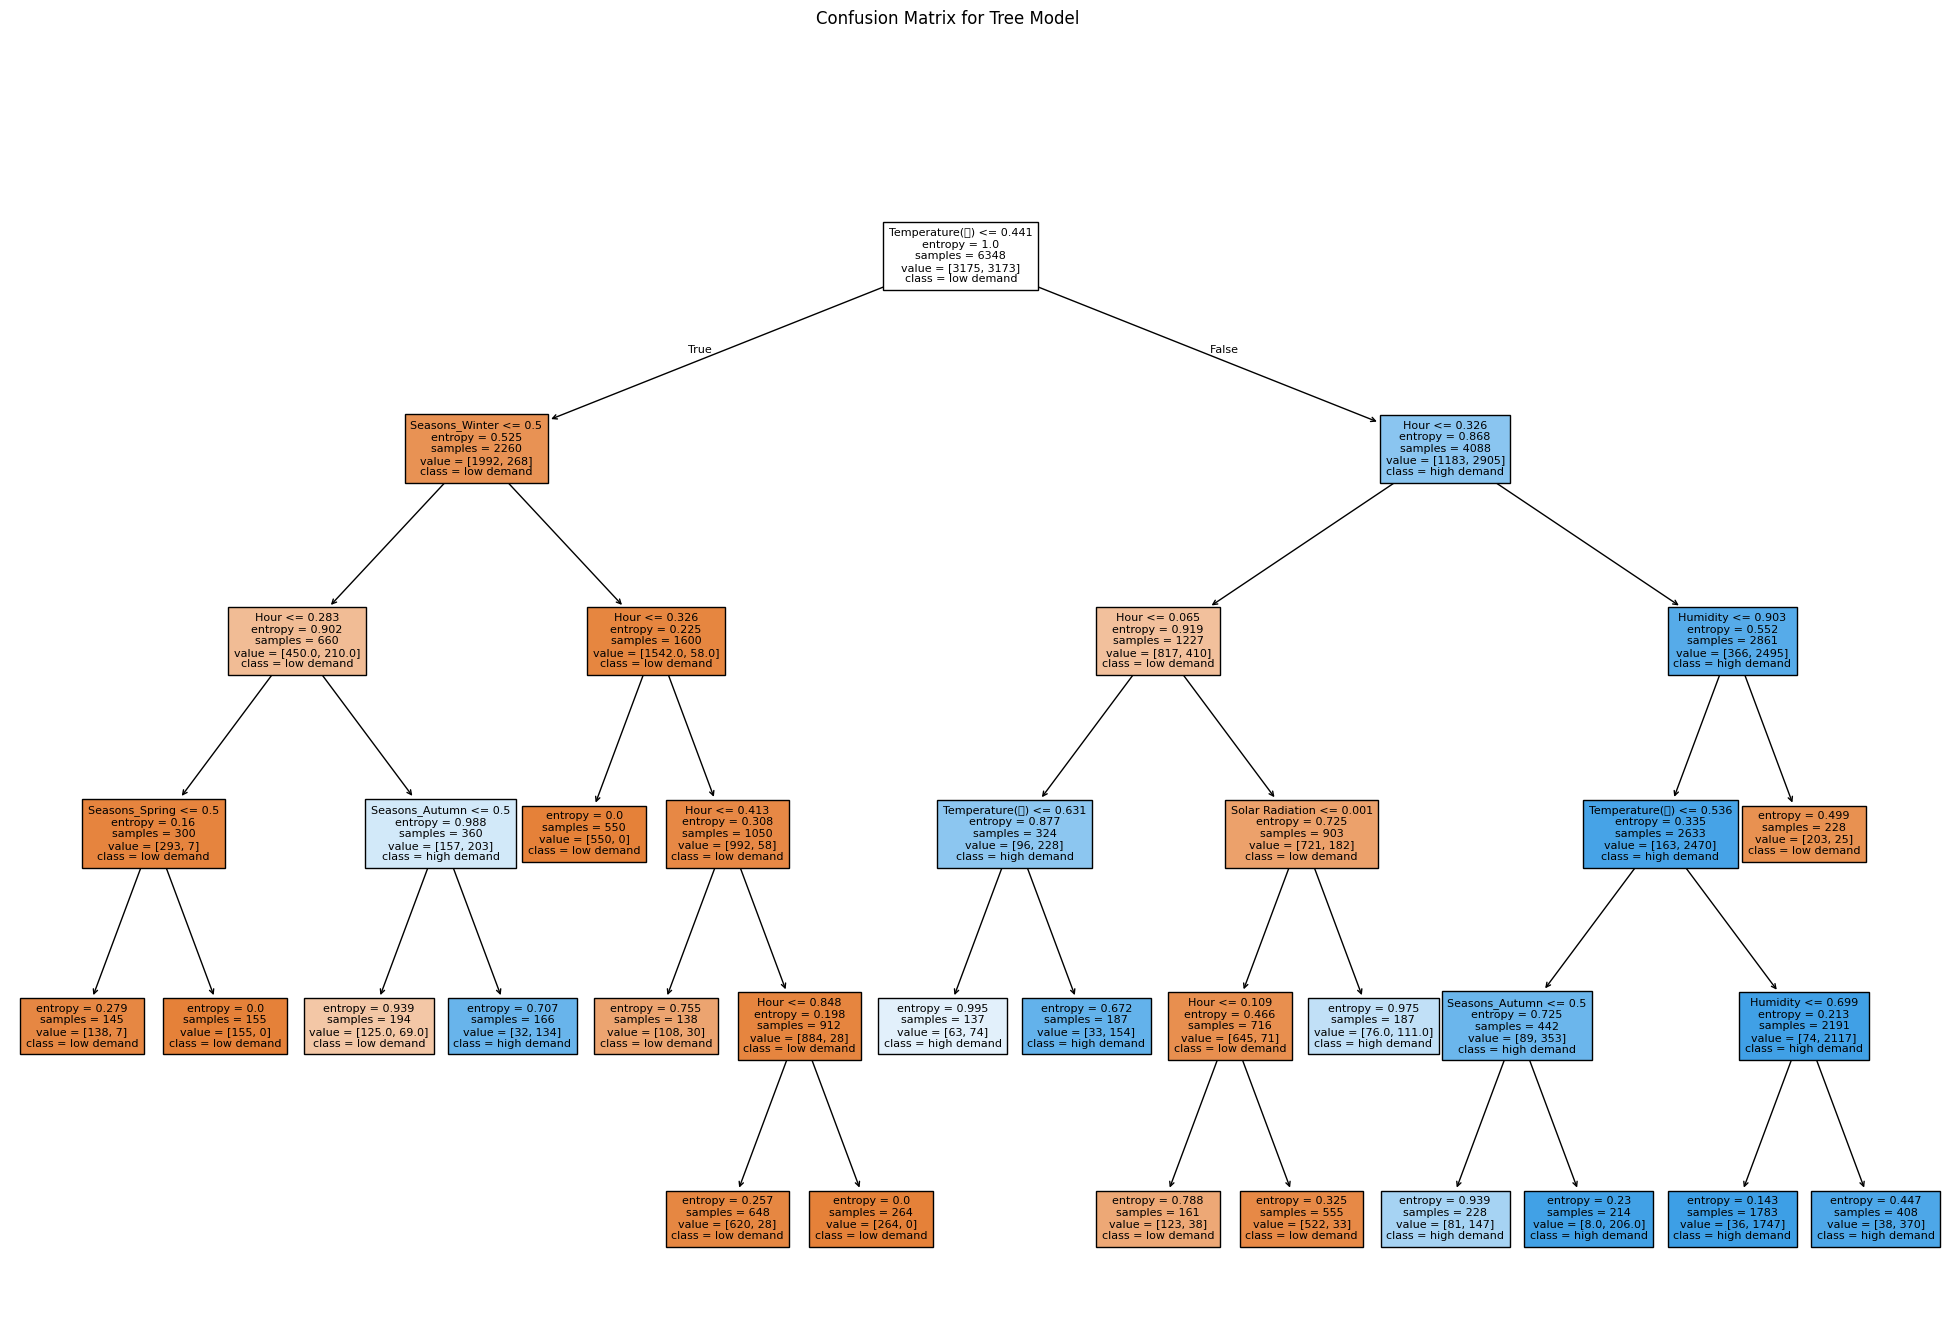

In [ ]:
# Visualize the best tree model
best_tree = grid.best_estimator_

fig = plt.figure(figsize=(25,15))    

plot_tree(decision_tree = best_tree, 
          feature_names = X_train.columns,      
          class_names = ['low demand','high demand'],        
          filled = True,                          
          fontsize = 8)    

fig.suptitle('Confusion Matrix for Tree Model')
plt.show()

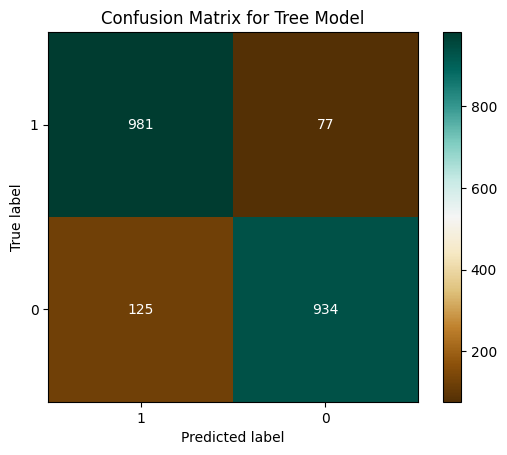

In [40]:
ConfusionMatrixDisplay.from_estimator(estimator = best_tree,
                                      X = X_test_scaled,
                                      y = y_test,
                                      cmap = 'BrBG',
                                      text_kw = {'color':'white'},
                                      labels=[1, 0])
plt.title("Confusion Matrix for Tree Model")
plt.show()

In [41]:
tree_pred = best_tree.predict(X_test_scaled)
recall_tree = recall_score(y_test, tree_pred, pos_label = 1)
print(f"Test-Recall for the best params:{(recall_tree* 100):.2f}%") 

Test-Recall for the best params:92.72%


### SVM model

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

param_grid = {
    "C": [1, 10, 100],
    "kernel": ["linear"]  # Only test linear kernel (faster than RBF)
}

svm_model = SVC(random_state=123)
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=5,
    scoring="recall",
    n_jobs=-1,  # Use all CPU cores for acceleration
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_c = best_params["C"]
best_recall_cv = grid_search.best_score_
best_model = grid_search.best_estimator_

svm_pred = best_model.predict(X_test_scaled)
recall_svm = recall_score(y_test, svm_pred, pos_label=1)

print(f"Best parameters: {best_params}")
print(f"Best C value: {best_c}")
print(f"Train-Recall for the best params: {best_recall_cv:.4f}") 
print(f"Test-Recall for the best params: {recall_svm:.4f}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'C': 100, 'kernel': 'linear'}
Best C value: 100
Train-Recall for the best params: 0.8298
Test-Recall for the best params: 0.8393


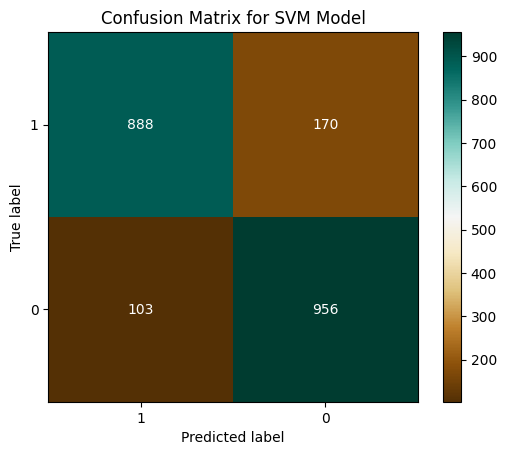

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    estimator=best_model,
    X=X_test_scaled,
    y=y_test,
    cmap="BrBG",
    text_kw={"color": "white"},
    labels=[1, 0])

plt.title("Confusion Matrix for SVM Model")
plt.show()